In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.client import device_lib 
from keras.callbacks import Callback
import keras.backend as K
from keras.callbacks import LearningRateScheduler


import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import multilabel_confusion_matrix,classification_report

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
rawData = pd.read_csv('skype.csv')
rawData = rawData[~rawData.isin([np.nan,np.inf,-np.inf]).any(1)] # drop all inf and nan rows
# rawTest = pd.read_csv('facebook.csv')
# rawTest = rawTest[~rawTest.isin([np.nan,np.inf,-np.inf]).any(1)]

In [ ]:
rawData

In [3]:
selectCols = rawData.drop(['Flow ID','Src IP','Dst IP','Timestamp','Web_service','Label'],axis=1)
original_X = np.array(selectCols.loc[:,['flow_start','Src Port','Fwd Pkt Len Min','Fwd Pkt Len Mean',
                                        'Fwd Pkt Len Std','Fwd Pkt Len Max','Bwd Pkt Len Min','Bwd Pkt Len Mean',
                                        'Bwd Pkt Len Std','Bwd Pkt Len Max','Flow Duration','Idle Max','Idle Mean',
                                        'App_protocol','Category','FirstNPkt_size','Tot Fwd Pkts','Tot Bwd Pkts',
                                       'Fwd Pkts/s','Bwd Pkts/s','Fwd IAT Tot','Fwd IAT Mean','Fwd IAT Std','Fwd IAT Max',
                                       'Fwd IAT Min','Bwd IAT Tot','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Max',
                                       'Bwd IAT Min','Bwd Header Len','Fwd Header Len']])
#X = np.array(rawData.loc[:,['Tot Fwd Pkts','Tot Bwd Pkts','TotLen Fwd Pkts','TotLen Bwd Pkts','Fwd Pkt Len Max','Bwd Pkt Len Max','FirstNPkt_size','Flow Duration','Flow Byts/s','Flow Pkts/s']])
Y = rawData.loc[:,['Label']]
category = pd.get_dummies(Y,columns=['Label']).columns
original_Y = np.array(pd.get_dummies(Y,columns=['Label']))

In [4]:
scalar = MinMaxScaler()
scalar.fit(original_X)
original_X = scalar.transform(original_X)

In [5]:
# Split dataset into 64% training, 16% test for the validation during the training phase
# 20% test set for evaluation 
Xt,XTes,Yt,YTes = train_test_split(original_X,original_Y,test_size=0.2,random_state=32) # 80% train , 20% test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xt,Yt,test_size=0.2,random_state=42) # 64% train2 , 16% test2

print("Training set size:", Xtrain.shape)
print("Validation set size:",Xtest.shape)
print("Evaluation set size:",XTes.shape)
print(category)

Training set size: (17724, 32)
Validation set size: (4432, 32)
Evaluation set size: (5540, 32)
Index(['Label_skype_audio', 'Label_skype_chat', 'Label_skype_video',
       'Label_unknown'],
      dtype='object')


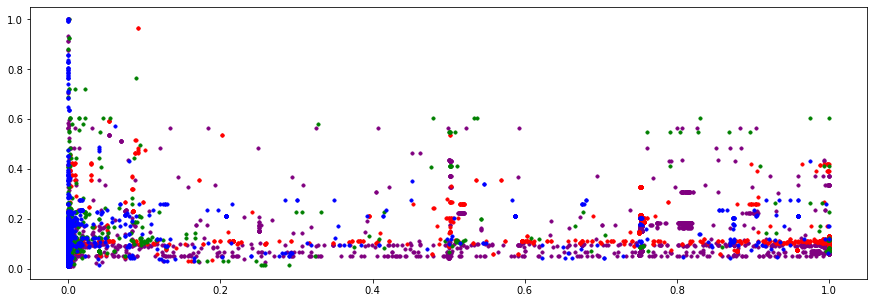

In [37]:
y1 = rawData.loc[rawData['Label']=='skype_audio']
y2 = rawData.loc[rawData['Label']=='skype_chat']
y3 = rawData.loc[rawData['Label']=='skype_video']
y4 = rawData.loc[rawData['Label']=='unknown']
fig, ax = plt.subplots(figsize=(15,5))
#colors = ['red','green','blue','purple']
plt.scatter(y1['Flow Duration'] / y1['Flow Duration'].max(), y1['FirstNPkt_size'] / y1['FirstNPkt_size'].max(), c='purple', linewidth=0.5,s = 12)
plt.scatter(y2['Flow Duration'] / y2['Flow Duration'].max(), y2['FirstNPkt_size'] / y2['FirstNPkt_size'].max(), c='red', linewidth=0.5,s = 12)
plt.scatter(y3['Flow Duration'] / y3['Flow Duration'].max(), y3['FirstNPkt_size'] / y3['FirstNPkt_size'].max(), c='green', linewidth=0.5,s = 12)
plt.scatter(y4['Flow Duration'] / y4['Flow Duration'].max(), y4['FirstNPkt_size'] / y4['FirstNPkt_size'].max(), c='blue', linewidth=0.5,s = 12)


In [ ]:
#Hangouts
ratio = {0:int(minimumSample * 1.8),
         1: int(minimumSample * 1.1),
         2: int(minimumSample * 1.4), 
         3: minimumSample 
        }

In [ ]:
#facebook 
ratio = {0:int(minimumSample * 1.7),
         1: minimumSample,
         2: minimumSample, 
         3: minimumSample 
        }

In [6]:
print("64% training data:")
print("target:",Ytrain.shape)
numberOfSample = []
for i in range(Ytrain.shape[1]):
    L = len(Ytrain[np.where(Ytrain[:,i] == 1)])
    print(f'{category[i]}: {L} ({L / Ytrain.shape[0]})')
    numberOfSample.append(L)
minimumSample = np.array(numberOfSample).min()

64% training data:
target: (17724, 4)
Label_skype_audio: 13885 (0.7834010381403747)
Label_skype_chat: 2821 (0.15916271721958924)
Label_skype_video: 380 (0.02143985556307831)
Label_unknown: 638 (0.0359963890769578)


In [7]:
print("20% test data:")
print(YTes.shape)

for i in range(YTes.shape[1]):
    L = len(YTes[np.where(YTes[:,i] == 1)])
    print(category[i],":",L)

20% test data:
(5540, 4)
Label_skype_audio : 4337
Label_skype_chat : 889
Label_skype_video : 111
Label_unknown : 203


In [10]:
#Skype 
# set the ratio of the number of samples for each class

actual = {
    0:0.78,
    1:0.16,
    2:0.02,
    3:0.04
}

ratio = {0:int(minimumSample * 1.2),
         1: int(minimumSample * 1.2),
         2:minimumSample, 
         3: int(minimumSample * 1.04)
        }

In [11]:
# Undersampling
rus = RandomUnderSampler(random_state=42,sampling_strategy=ratio)
X, Y = rus.fit_resample(Xtrain,Ytrain)
print("After undersampling")
for i in range(len(category)):
    print(category[i],":",len(Y[np.where(Y[:,i]==1)]))
print(X.shape)

After undersampling
Label_skype_audio : 456
Label_skype_chat : 456
Label_skype_video : 380
Label_unknown : 395
(1687, 32)


In [ ]:
feature_names = list(selectCols.columns)
forest = RandomForestClassifier(random_state=0)
forest.fit(Xtrain, Ytrain)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
result = permutation_importance(
    forest, Xtrain, Ytrain, n_repeats=10, random_state=21, n_jobs=2
)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [15]:
n_x = X.shape[1]
encode_n_x = 40
n_y = Y.shape[1]
# save best model during the training process
iteration_checkpoint = keras.callbacks.ModelCheckpoint(
    f'models/graph_model_iteration_10.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

gridSearchSet = {
    'alpha':[0.005,0.003,0.001,0.05,0.03,0.01,0.5,0.3,0.1],
    'optimizer': {'SGD':keras.optimizers.SGD, 'RMSprop': keras.optimizers.RMSprop, 'Adagrad': keras.optimizers.Adagrad, 
                  'Adadelta':keras.optimizers.Adadelta, 'Adam':keras.optimizers.Adam, 
                  'Adamax':keras.optimizers.Adamax, 'Nadam':keras.optimizers.Nadam},
    'epochs': [60,120,180,240,300],
    'batch':[5,10,15,20]
}


def autoEncoder():
    input_dim = keras.Input(shape=(n_x,))
    encoder_output = keras.layers.Dense(encode_n_x,activation='relu')(input_dim)
  
    decoder_output = keras.layers.Dense(n_x,activation='softmax')(encoder_output)
    autoencoder = keras.Model(input_dim, decoder_output)
    
    encoder = keras.Model(input_dim,encoder_output)
    ein = keras.Input(shape=(encode_n_x,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.Model(ein,decoder_layer(ein))
    return autoencoder,encoder,decoder

def baseline_model(lr,op='Adam'):
    # create model
    model = Sequential()
    opt = gridSearchSet['optimizer'][op](lr)
    model.add(Dense(500, input_dim=n_x, activation='relu'))
    model.add(Dense(400, input_dim=500, activation='relu'))
    model.add(Dense(300, input_dim=400, activation='relu'))
    model.add(Dense(200, input_dim=300, activation='relu'))
    model.add(Dense(50, input_dim=200, activation='relu'))
    model.add(Dense(n_y, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
auto_encoder,encoder,decoder = autoEncoder()
auto_encoder.summary()
encoder.summary()
decoder.summary()

In [ ]:
auto_encoder.compile(optimizer='adam',loss='binary_crossentropy')
auto_encoder.fit(Xtrain,Xtrain,epochs=10,batch_size=5,validation_data=(XTest,XTest))

In [ ]:
encode_Xtrain = encoder.predict(Xtrain)
encode_Xtest =encoder.predict(XTest)
#decode_res = decoder.predict(encode_Xtrain)

In [16]:
def step_decay_schedule(initial_lr, decay_factor, step_size):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

In [19]:
# Use Kfold cross validation to avoid overfitting
# 500-300-200-50 0.001
# 500-400-300-200-100 0.001
result = []
bestModels = {}
ep_size = 100
soFarBest = [None,0]
# early stop call back function
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
for bz in gridSearchSet['batch']:
    for lr in gridSearchSet['alpha']:
        key = str(lr) + "-" + 'Adam' + "-" + str(bz)
        kfold = KFold(n_splits= 10, shuffle=True)
        soFarBest = [None,0]
        for train_index, test_index in kfold.split(X):
            #x_train,x_test=encode_Xtrain[train_index],encode_Xtrain[test_index]
            x_train,x_test=X[train_index],X[test_index]
            y_train,y_test=Y[train_index],Y[test_index]

            model = baseline_model(lr)
            #lr_finder = LRFinder(min_lr = 0.001, max_lr = 0.01, steps_per_epoch=np.ceil(ep_size/b_szie),epochs=3)
            #lr_sched = step_decay_schedule(initial_lr=lr, decay_factor=0.80, step_size=25)
            model.fit(x_train,y_train,epochs=100,batch_size=bz,callbacks=[lr_sched,callback],verbose=0)
            test_loss, test_acc = model.evaluate(Xtest,Ytest)

            if test_acc > soFarBest[1]:
                soFarBest[0] = model
                soFarBest[1] = test_acc

        bestModels[key] = [soFarBest[0],soFarBest[1]]
        print(key,'Acc:',soFarBest[1])

139/139 [==============================] - 0s 655us/step - loss: 0.7065 - accuracy: 0.9305
0.005-Adam-5 Acc: 0.9354693293571472
139/139 [==============================] - 0s 683us/step - loss: 0.3023 - accuracy: 0.9174
0.003-Adam-5 Acc: 0.9329873919487
139/139 [==============================] - 0s 665us/step - loss: 0.3535 - accuracy: 0.9325
0.001-Adam-5 Acc: 0.9325361251831055
139/139 [==============================] - 0s 660us/step - loss: 0.4148 - accuracy: 0.9009
0.05-Adam-5 Acc: 0.929602861404419
139/139 [==============================] - 0s 676us/step - loss: 0.3262 - accuracy: 0.9264
0.03-Adam-5 Acc: 0.9291516542434692
139/139 [==============================] - 0s 669us/step - loss: 0.4883 - accuracy: 0.9147
0.01-Adam-5 Acc: 0.9343411326408386
139/139 [==============================] - 0s 683us/step - loss: 0.4370 - accuracy: 0.9000
0.5-Adam-5 Acc: 0.932084858417511
139/139 [==============================] - 0s 676us/step - loss: 0.4377 - accuracy: 0.9147
0.3-Adam-5 Acc: 0.93073

In [20]:
res = [None,0,""]
acc_res = []
for key in bestModels:
    test_loss, test_acc = bestModels[key][0].evaluate(XTes,YTes)
    #predictions = bestModels[k][0].predict(XTest)
    print(key,"Accuracy(Test): %.2f%%" % (test_acc*100))
    if test_acc > res[1]:
        res[0] = bestModels[key][0]
        res[1] = test_acc
        res[2] = key
    acc_res.append(test_acc)

174/174 [==============================] - 0s 879us/step - loss: 4.6477 - accuracy: 0.9271
0.005-Adam-5 Accuracy(Test): 92.71%
174/174 [==============================] - 0s 868us/step - loss: 2.2917 - accuracy: 0.9247
0.003-Adam-5 Accuracy(Test): 92.47%
174/174 [==============================] - 0s 908us/step - loss: 0.5237 - accuracy: 0.9267
0.001-Adam-5 Accuracy(Test): 92.67%
174/174 [==============================] - 0s 856us/step - loss: 0.5187 - accuracy: 0.9245
0.05-Adam-5 Accuracy(Test): 92.45%
174/174 [==============================] - 0s 847us/step - loss: 2.1690 - accuracy: 0.9224
0.03-Adam-5 Accuracy(Test): 92.24%
174/174 [==============================] - 0s 862us/step - loss: 1.1860 - accuracy: 0.9258
0.01-Adam-5 Accuracy(Test): 92.58%
174/174 [==============================] - 0s 847us/step - loss: 0.3201 - accuracy: 0.9245
0.5-Adam-5 Accuracy(Test): 92.45%
174/174 [==============================] - 0s 838us/step - loss: 0.4551 - accuracy: 0.9253
0.3-Adam-5 Accuracy(Test)

In [21]:
print(res[-1],"Accuracy(Test): %.2f%%" % (res[1]*100))

0.01-Adam-15 Accuracy(Test): 93.16%


In [22]:
acc_res = np.array(acc_res)
y_true = YTes
y_pred = res[0].predict(XTes)
for i in range(len(y_pred)):
    col_num = y_pred[i].argmax()
    for j in range(len(y_pred[i])):
        y_pred[i][j] = 0
    y_pred[i][col_num] = 1
cm = multilabel_confusion_matrix(y_true, y_pred)

In [23]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"fontsize":16},cbar=True, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label',fontsize= 16)
    axes.set_xlabel('Predicted label',fontsize= 16)
    axes.set_title(class_label,fontsize= 13)


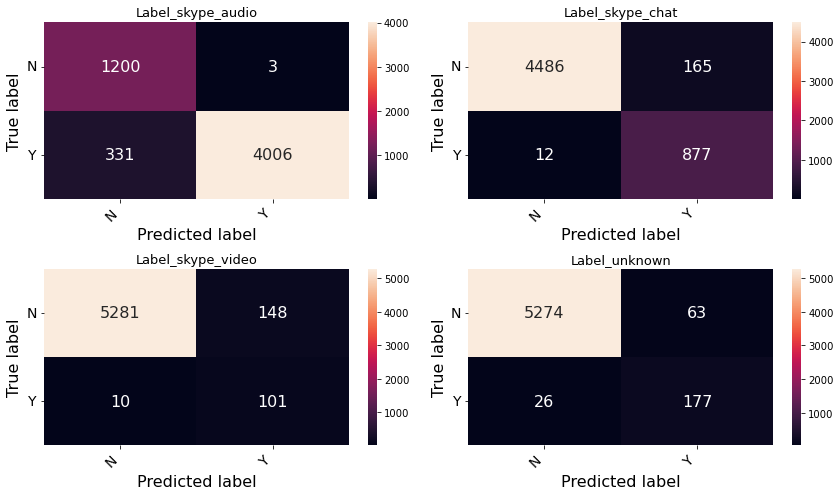

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, category):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [25]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4337
           1       0.84      0.99      0.91       889
           2       0.41      0.91      0.56       111
           3       0.74      0.87      0.80       203

   micro avg       0.93      0.93      0.93      5540
   macro avg       0.75      0.92      0.81      5540
weighted avg       0.95      0.93      0.94      5540
 samples avg       0.93      0.93      0.93      5540



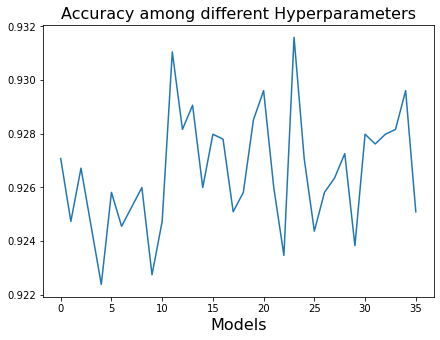

In [35]:
accRes = np.array(acc_res)
fig, ax = plt.subplots(figsize=(7,5))
    
plt.plot(np.arange(accRes.shape[0]),accRes)

plt.xlabel('Models',fontsize=16)
plt.title('Accuracy among different Hyperparameters',fontsize=16)
plt.show()

In [ ]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()